# Lending Value model for SWI stocks

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats

## Get the data

In [2]:
start = '2018-04-01' # start date of time series
today = '2021-04-01' # end date of time series

# SWI20 (yahoo) tickers
swi = ['SGSN.SW','SCMN.SW','GIVN.SW','ZURN.SW','NOVN.SW',
          'ROG.SW','CSGN.SW','LHN.SW','ABBN.SW','UHR.SW',
          'LONN.SW','SLHN.SW','PGHN.SW','GEBN.SW','NESN.SW',
          'SREN.SW','CFR.SW','UBSG.SW','SIKA.SW','ALC.SW']

# Names of those SWI firms
swi_names = ['SGS','Swisscom','Givaudan','Zurich Insurance Group','Novartis',
         'Roche','Credit Suisse','LafargeHolcim','ABB','Swatch Group',
         'Lonza','Swiss Life Holding','Partners Group','Geberit','Nestle',
         'Swiss Re','Richemont','UBS','Sika','Alcon']

# more_ticks = ['ADEN.SW','BAER.SW','CLN.SW','GIVN.SW','KNIN.SW','SOON.SW']
# more_names = ['Adecco Group','Julius Bär','Clariant','Givaudan','Kuehne + Nagel International','Sonova']

In [3]:
# Fetch daily price and volume data from yahoo; calculate log prices
def get_data(ticks,start_date,end_date):    
    prices = []
    for i in ticks:
        closing = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-1]
        prices.append(closing)

    prices = pd.concat(prices,axis=1)
    prices.columns = ticks
    prices_logs = np.log(prices/prices.shift(1))

    volumes = []
    for i in ticks:
        vol = pdr.DataReader(i,
                                 data_source='yahoo',
                                 start=start_date,
                                 end=end_date
                                ).iloc[:,-2]
        volumes.append(vol)

    volumes = pd.concat(volumes,axis=1)
    volumes.columns = ticks
    
    return prices, prices_logs, volumes

In [4]:
# SWI stocks prices for the last 3 years
swi_prices = get_data(swi,start,today)[0]
# Same but log prices
swi_logprices = get_data(swi,start,today)[1]
# Same but volume
swi_volumes = get_data(swi,start,today)[2]

## Functions

In [8]:
# Calculate ADTV and sort them by value - last month
def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    adtv_sorted = adtv.sort_values(by='ADTV - Last month',ascending=False)
    return adtv_sorted

# Return mean of a time series
def mean(log_prices):
    return log_prices.mean()

# Return standard deviation of a time series
def std(log_prices):
    return log_prices.std()

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta,gamma,x):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv_adj = ( (1-alpha)*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*stats.norm.ppf(epsilon))) )
    return lv_adj

# Estimate gamma by using ADTV
def gamma_est(ADTV,a_hat,b_hat):
    return 10**a_hat*ADTV**b_hat

# Plot prices or volumes
def plot_volumes(prices):
    tcks = prices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(prices.iloc[:,i])
        ax[i].set_title(tcks[i])
    plt.tight_layout()
    
# Plot log prices
def plot_volatility(logprices):
    tcks = logprices.columns
    fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                           figsize=[16,9*2],dpi=100)
    for i in range(len(tcks)):
        ax[i].plot(logprices.iloc[:,i])
        ax[i].axhline(y=0,c='k')
        ax[i].set_title(tcks[i])
    plt.tight_layout()

In [12]:
# ADTV sorted by value, descending
ADTV(swi_volumes).round(1)

,ADTV - Last month,ADTV - Last three years
CSGN.SW,19667326.2,12576497.9
UBSG.SW,14850054.6,16708065.2
ABBN.SW,6338459.8,7661980.7
NOVN.SW,5902735.2,5850626.7
NESN.SW,4974456.2,5773732.2
LHN.SW,1982232.1,2584486.6
ROG.SW,1718565.1,1847148.2
CFR.SW,1389445.0,2076559.3
SREN.SW,1295295.2,1614857.5
ALC.SW,985499.4,1829261.7


In [13]:
# Select the most liquid, 5th liquid, 11th liquid, 16th liquid and the least liquid stock in the SMI index
selection = [0,4,10,15,19]
ADTV(swi_volumes).iloc[selection,:]

selected_ticks = list(ADTV(swi_volumes).iloc[selection,:].index) # tick names for the selected stocks
selected_prices = swi_prices[selected_ticks] # price timeseries for the selected stocks
selected_logprices = swi_logprices[selected_ticks] # log-price timeseries for the selected stocks
selected_volumes = swi_volumes[selected_ticks] # volume timeseries for the selected stocks

In [14]:
# Descriptive stats for price time series of selected stocks
selected_prices.describe()

,CSGN.SW,NESN.SW,ZURN.SW,SLHN.SW,SGSN.SW
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,11.391137,94.301848,319.676624,381.858976,2333.187197
std,1.813689,12.572072,42.964727,60.989071,158.022211
min,6.200624,68.300575,250.879578,246.679886,1850.626587
25%,10.233524,80.379700,277.607910,326.705338,2228.188293
50%,11.369372,100.000168,319.448914,370.949997,2330.145874
75%,12.414352,104.080818,359.775009,442.747879,2414.533203
max,15.771125,111.279999,413.495422,492.792725,2720.000000


### Plots: price, volatility and volume time series

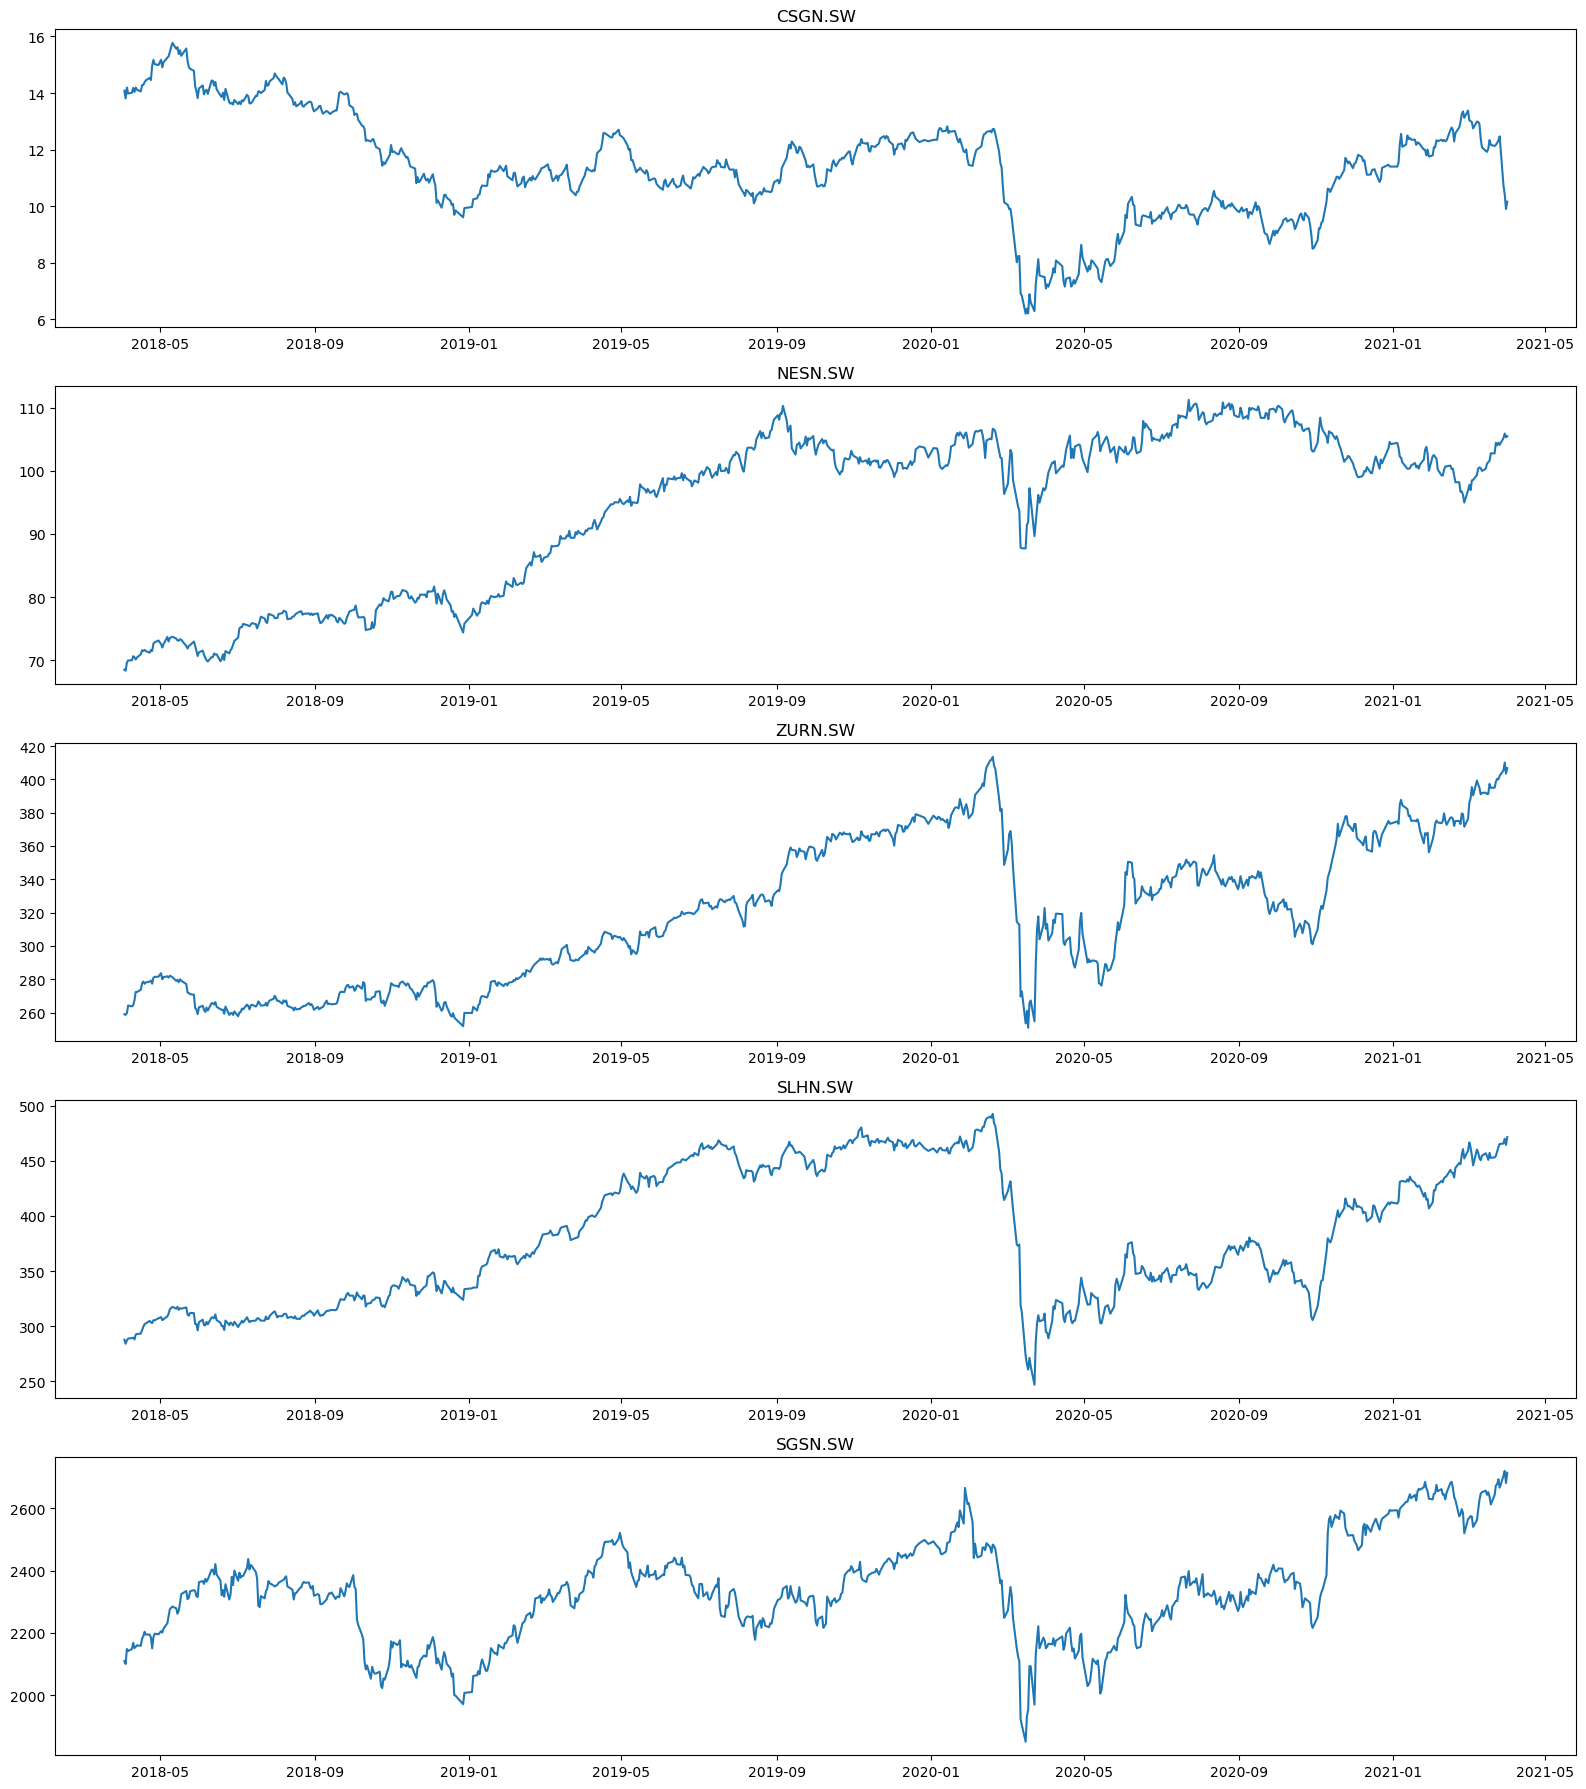

In [15]:
# Stock price time series
plot_volumes(selected_prices)

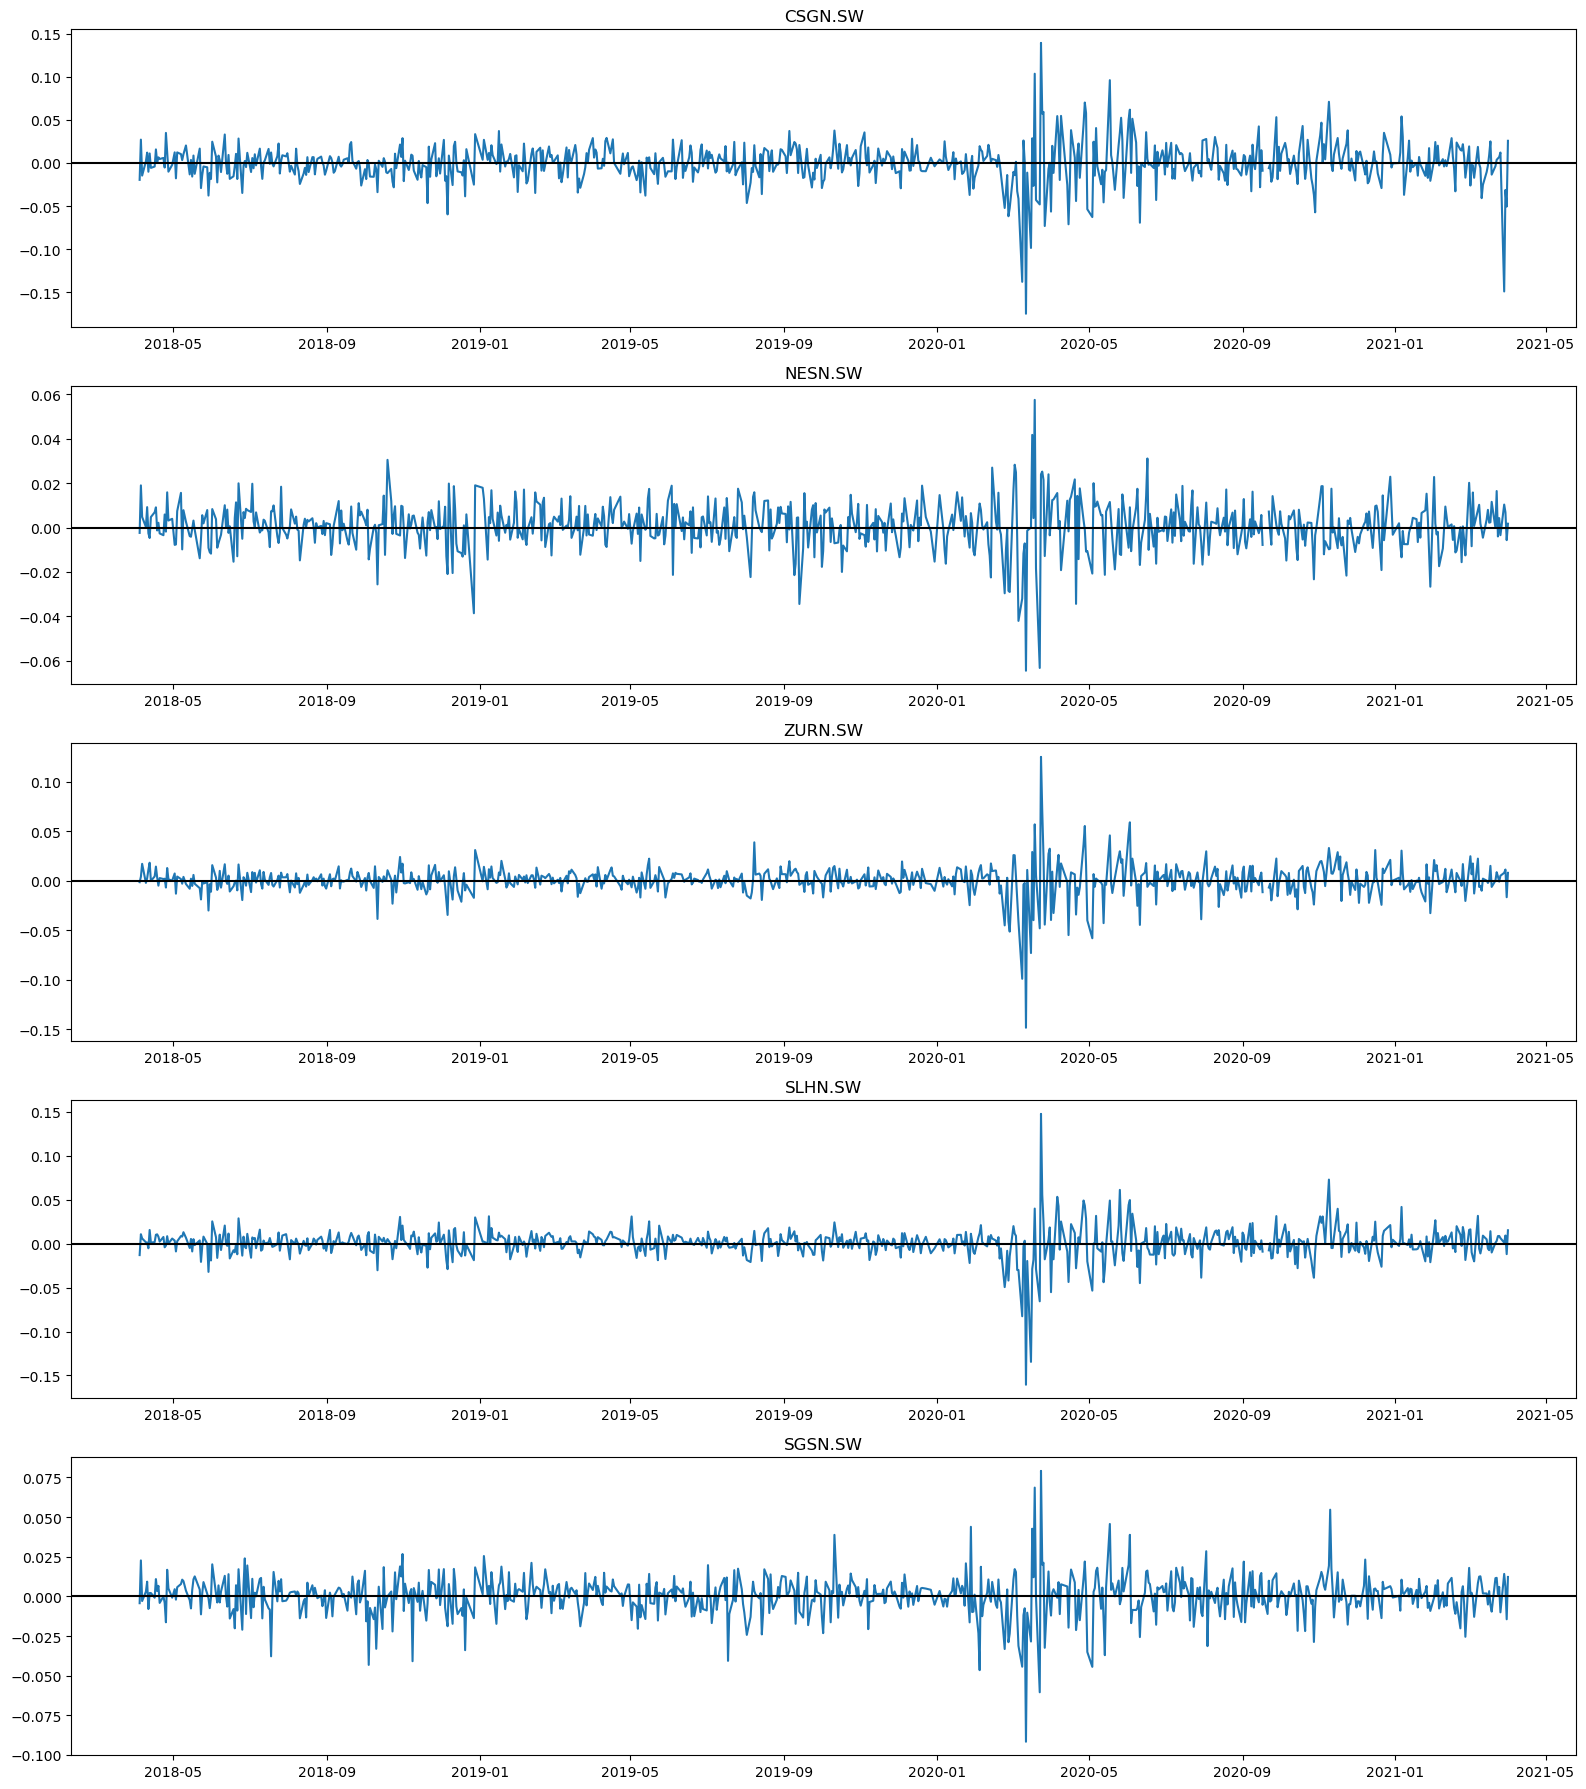

In [16]:
# Stock volatility time series
plot_volatility(selected_logprices)

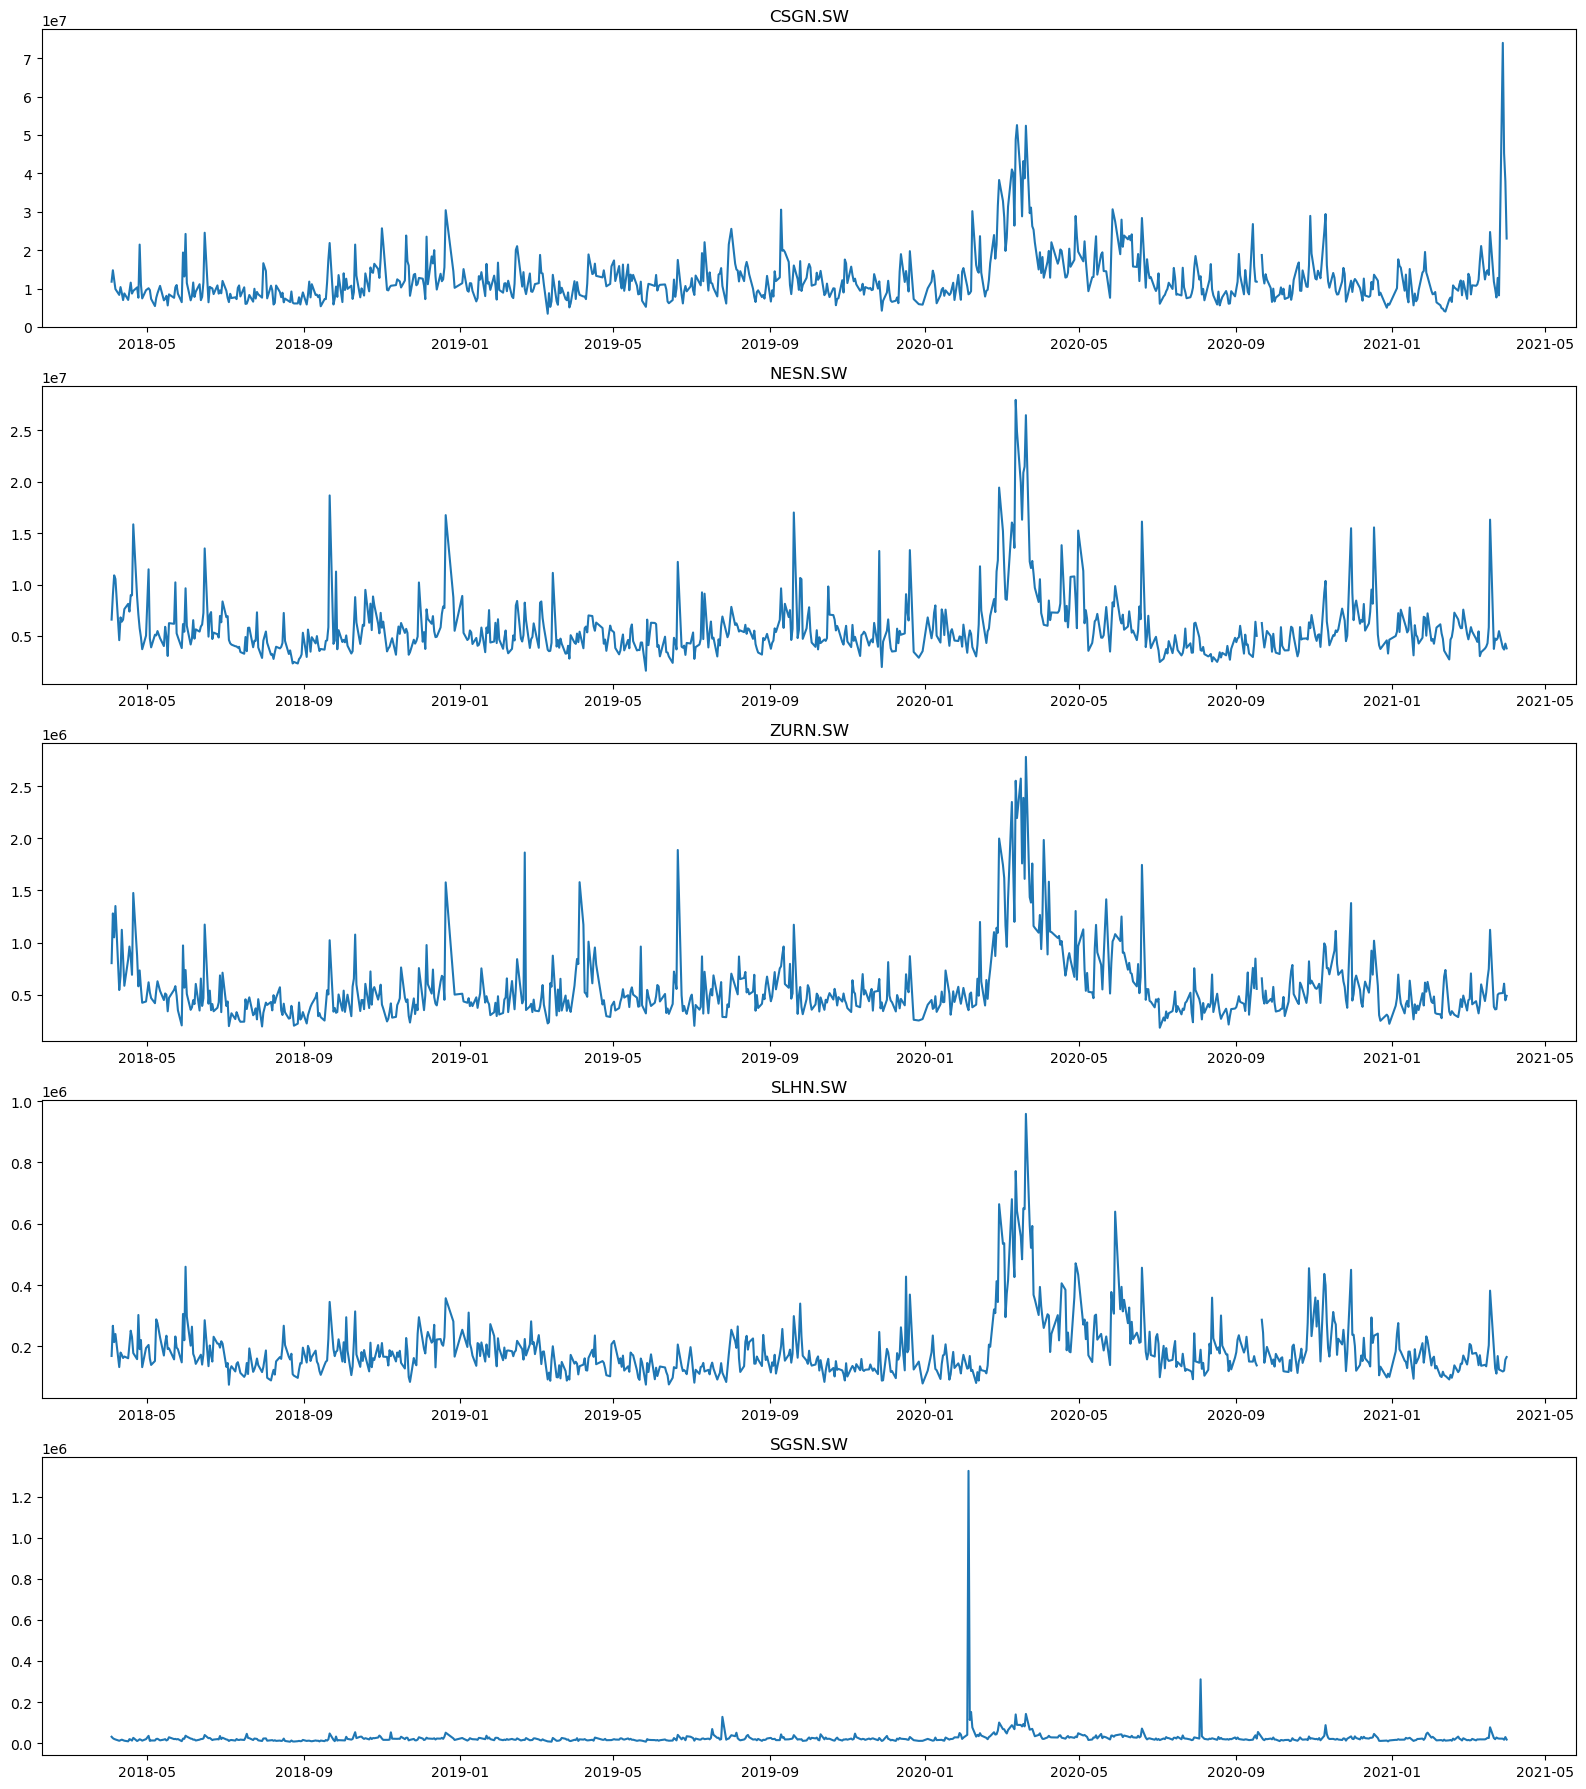

In [17]:
# Stock trading volume time series
plot_volumes(selected_volumes)

## Base Lending Value Model

### Parameters

In [18]:
alpha = 0.25
epsilon = 0.01
delta = 10

### SMI

In [19]:
smi_lvs = []
for i in range(len(swi_logprices.columns)):
    lv = LV(swi_logprices.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv)
smi_lvs = pd.DataFrame(smi_lvs,index=swi)
smi_lvs.columns = ['Lending Value']

smi_lvs['Drift %'] = GBM(swi_logprices)[0]*100
smi_lvs['Diffusion %'] = GBM(swi_logprices)[1]*100

smi_lvs = smi_lvs.sort_values(by='Lending Value',ascending=False)
smi_lvs.round(2)

,Lending Value,Drift %,Diffusion %
NESN.SW,0.91,0.53,0.11
SCMN.SW,0.90,0.25,0.13
GIVN.SW,0.90,0.71,0.15
NOVN.SW,0.89,0.32,0.16
ROG.SW,0.89,0.50,0.17
SGSN.SW,0.89,0.25,0.17
GEBN.SW,0.88,0.52,0.19
ZURN.SW,0.87,0.52,0.24
PGHN.SW,0.86,0.77,0.26
ABBN.SW,0.86,0.49,0.27


In [20]:
# LV for selected stocks
selected_lv = smi_lvs.loc[selected_ticks,:].sort_values(by='Lending Value',ascending=False)
selected_lv.round(2)

,Lending Value,Drift %,Diffusion %
NESN.SW,0.91,0.53,0.11
SGSN.SW,0.89,0.25,0.17
ZURN.SW,0.87,0.52,0.24
SLHN.SW,0.85,0.58,0.29
CSGN.SW,0.80,-0.58,0.54


## Adjusted Lending Value Model

### Gamma parameter for selected stocks

In [23]:
a_hat_juri = -1.87096
b_hat_juri = -0.794554
selected_ADTV = ADTV(selected_volumes)['ADTV - Last month']

selected_gamma = []
for i in selected_ADTV:
    est_i = gamma_est(i,a_hat_juri,b_hat_juri)
    selected_gamma.append(est_i)

selected_gamma = pd.DataFrame(selected_gamma,columns=['Gamma'])
selected_gamma.index = selected_ADTV.index

selected_gamma

,Gamma
CSGN.SW,2.156580e-08
NESN.SW,6.428564e-08
ZURN.SW,3.919104e-07
SLHN.SW,9.673288e-07
SGSN.SW,4.536671e-06


### Adjusted LV for SGS stock

In [24]:
x_range = np.arange(0,10**8,10**3)

In [25]:
sgs_lvs = []
for i in x_range:
    lv_adj = LV_adj(swi_logprices['SGSN.SW'],
                    alpha,epsilon,delta,
                    selected_gamma.loc['CSGN.SW',:][0],
                    i)
    sgs_lvs.append(lv_adj)

In [26]:
sgs_lvs

[0.8857478800238449,
 0.8857231387806848,
 0.8856983983861351,
 0.8856736588401579,
 0.8856489201427152,
 0.8856241822937693,
 0.8855994452932818,
 0.8855747091412155,
 0.885549973837532,
 0.8855252393821937,
 0.8855005057751625,
 0.8854757730164006,
 0.88545104110587,
 0.885426310043533,
 0.8854015798293516,
 0.8853768504632881,
 0.8853521219453043,
 0.8853273942753626,
 0.885302667453425,
 0.8852779414794536,
 0.8852532163534106,
 0.8852284920752582,
 0.8852037686449583,
 0.8851790460624733,
 0.8851543243277653,
 0.8851296034407963,
 0.8851048834015285,
 0.8850801642099241,
 0.8850554458659451,
 0.8850307283695539,
 0.8850060117207126,
 0.884981295919383,
 0.8849565809655277,
 0.8849318668591085,
 0.8849071536000881,
 0.884882441188428,
 0.8848577296240908,
 0.8848330189070386,
 0.8848083090372334,
 0.8847836000146376,
 0.8847588918392132,
 0.8847341845109225,
 0.8847094780297275,
 0.8846847723955905,
 0.8846600676084738,
 0.8846353636683394,
 0.8846106605751496,
 0.8845859583288667,

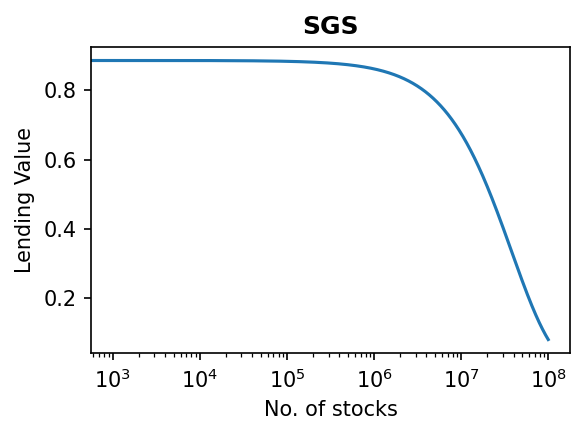

In [27]:
fig,ax = plt.subplots(1,1,figsize=[4,3],dpi=150)
ax.plot(x_range,sgs_lvs)
ax.set_xscale('log')
ax.set_xlabel('No. of stocks')
ax.set_ylabel('Lending Value')
ax.set_title('SGS',fontweight='bold')
plt.tight_layout()

---

## Hubert's todo

- Make the plot for each selected stock
- Choose some x and compare LV with adjusted LV in one table
- (Model the lombard process)
- CAPM
- VaR and ES
- Backtesting
- Look through other papers
- Prepare the theory part